## This dataset soure is from https://dacon.io/competitions/official/235837/data 

- This program is about predicting future rental numbers of bicycles at Seoul Korea.
- It's just personal toy project for ML.




In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

train = pd.read_csv("/content/drive/MyDrive/open/따릉이/train.csv")
test = pd.read_csv('/content/drive/MyDrive/open/따릉이/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/open/따릉이/sample_submission.csv')

<h3>EDA: See data composition and relationship first</h3>

In [194]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [195]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


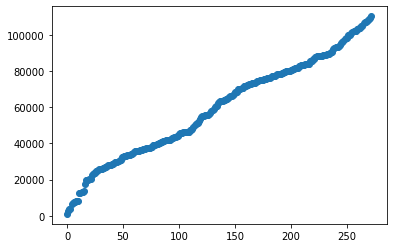

In [196]:
import matplotlib.pyplot as plt
# 이상치 확인
plt.figure(figsize=(6,4))
plt.scatter(range(len(train)), np.sort(train['number_of_rentals'].values))
plt.show()

<h4> Date to 'year', 'month', 'day'</h4>

In [197]:
train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])

train['day']=pd.DatetimeIndex(train['date_time']).day
test['day']=pd.DatetimeIndex(test['date_time']).day

train['month']=pd.DatetimeIndex(train['date_time']).month
test['month']=pd.DatetimeIndex(test['date_time']).month

train['year']=pd.DatetimeIndex(train['date_time']).year
test['year']=pd.DatetimeIndex(test['date_time']).year

train['weekday']=pd.DatetimeIndex(train['date_time']).weekday
test['weekday']=pd.DatetimeIndex(test['date_time']).weekday

- Check the heatmap first for feature engineering.


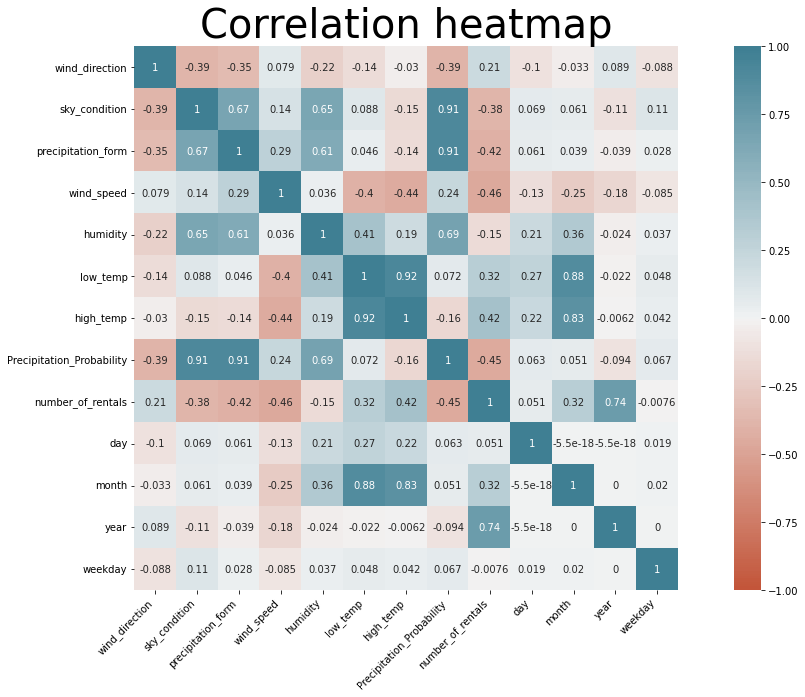

In [198]:
# Over 60% correlation maybe smae kind of features
b_num = train.select_dtypes(np.number)
corr = b_num.corr()
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Correlation heatmap', fontsize=40)
plt.show()

- Check the same kind of features to reduce them.

In [199]:
print(train['humidity'].corr(train['sky_condition']))
print(train['precipitation_form'].corr(train['Precipitation_Probability']))

0.6513205647712357
0.9106089542607185


In [200]:
train['precipitation_form'].corr(train['sky_condition'])

0.6738137525457335

To check relation between Precipitation_Probability and  number_of_rentals

In [201]:
labels = np.arange(0, 101, 20)
Precipitation_Probability_seg = pd.Series(list(pd.cut(train['Precipitation_Probability'], 6, labels=labels)), name='Precipitation_Probability_seg')
train = pd.concat([train, Precipitation_Probability_seg], axis=1)

In [202]:
Precipitation_Probability_seg = pd.Series(list(pd.cut(test['Precipitation_Probability'], 6, labels=labels)), name='Precipitation_Probability_seg')
test = pd.concat([test, Precipitation_Probability_seg], axis=1)

In [203]:
# By change of precipitation probability number of rentals change
train[["Precipitation_Probability_seg", "number_of_rentals"]].groupby(['Precipitation_Probability_seg'], as_index=False).mean().sort_values(by='number_of_rentals', ascending=False)


,Precipitation_Probability_seg,number_of_rentals
0,0,67687.374150
1,20,57625.728571
2,40,55041.607143
3,60,34089.500000
4,80,16129.857143
5,100,4146.333333


<h2>Visulazation</h2>
- Visualazation is important find insight
- Build function to check easily

In [204]:
def visual_bar(feature):
    plot = train.groupby(feature)['number_of_rentals'].mean()
    sns.barplot(plot.index,plot.values)

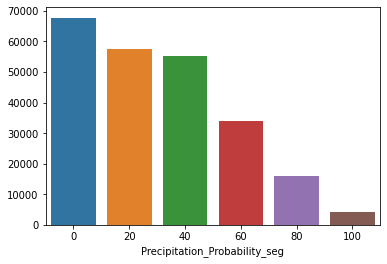

In [205]:
visual_bar('Precipitation_Probability_seg')

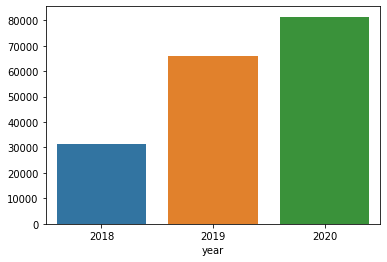

In [206]:
visual_bar('year')

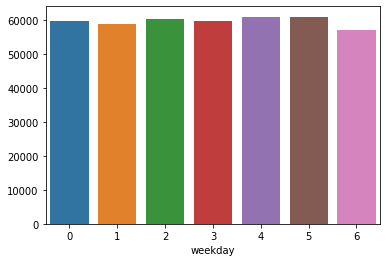

In [207]:
visual_bar('weekday')

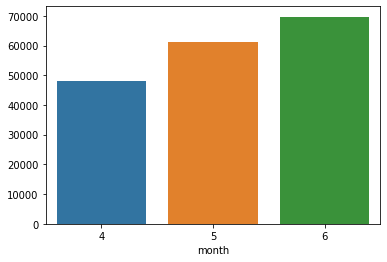

In [208]:
visual_bar('month')

- Create new variables for better prediction.
- Using tempeture features and temperature and humidity.

In [209]:
# train data
# add new variable
train['Temperature'] = (train['low_temp'] + train['high_temp'])/2
train['discomfort_index'] = (9/5)*train['Temperature']-0.55*((1-train['humidity']/100))*((9/5)*train['Temperature']-26)+32

# grouping
train.loc[train['Precipitation_Probability'] <40, 'Precipitation_Probability'] = 0
train.loc[train['Precipitation_Probability'] >=40, 'Precipitation_Probability'] = 1

train.reset_index(drop = True, inplace = True)
train.reset_index(drop = True, inplace = True)

# test data
test['Temperature'] = (test['low_temp'] + test['high_temp'])/2
test['discomfort_index'] = (5/9)*test['Temperature']-0.55*((100-test['humidity'])/100)*((5/9)*test['Temperature']-26)+32

test.loc[test['Precipitation_Probability'] <40, 'Precipitation_Probability'] = 0
test.loc[test['Precipitation_Probability'] >=40, 'Precipitation_Probability'] = 1

test.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [210]:
train.drop(['date_time','wind_direction', 'humidity', 'Precipitation_Probability_seg','low_temp', 'high_temp', 'precipitation_form', 'day'], axis = 1, inplace= True)
test.drop(['date_time','wind_direction', 'humidity', 'low_temp', 'high_temp', 'precipitation_form', 'day', 'Precipitation_Probability_seg'], axis = 1, inplace= True)

In [211]:
train.head()

,sky_condition,wind_speed,Precipitation_Probability,number_of_rentals,month,year,weekday,Temperature,discomfort_index
0,4.000,3.050,0.0,22994,4,2018,6,16.800,61.657000
1,2.950,3.278,0.0,28139,4,2018,0,15.906,60.194302
2,2.911,2.690,0.0,26817,4,2018,1,12.814,55.470688
3,3.692,3.138,1.0,26034,4,2018,2,10.340,51.755888
4,4.000,3.186,1.0,2833,4,2018,3,8.148,48.300569


<h3> Feature extraction </h3>
 Check the bset corrleated features over 0.3

Index(['sky_condition', 'wind_speed', 'Precipitation_Probability',
       'number_of_rentals', 'month', 'year', 'Temperature',
       'discomfort_index'],
      dtype='object')


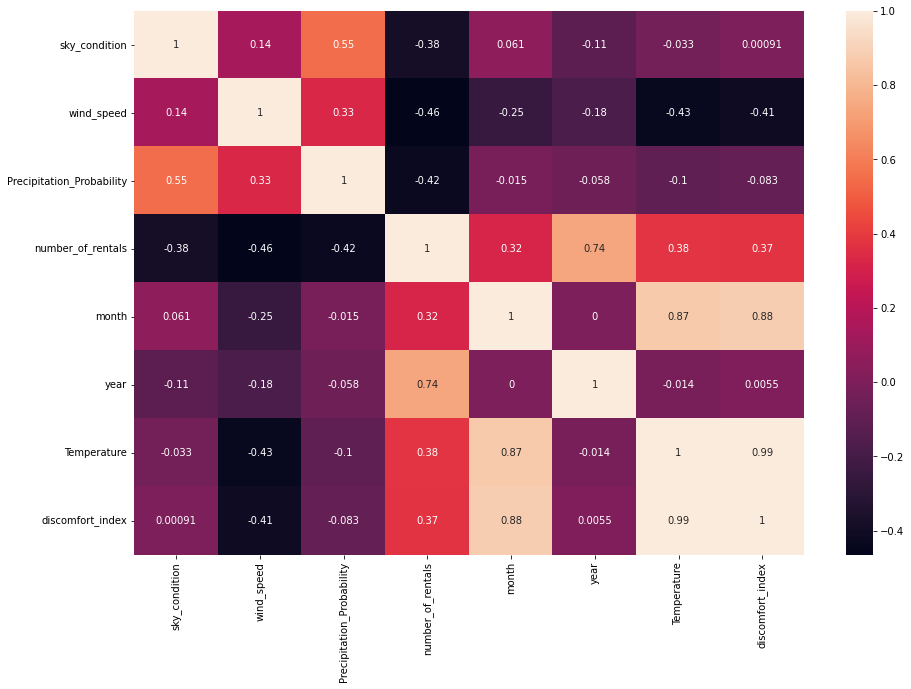

In [212]:
cor = train.corr()
top_feature = cor.index[abs(cor['number_of_rentals']) >= 0.3]
print(top_feature)
top_corr = train[top_feature].corr()
plt.figure(figsize=(15,10))
sns.heatmap(top_corr, annot=True)
plt.xticks(rotation=90)
plt.show()

Import ML libraries

In [213]:
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score ,roc_curve, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score
from lightgbm import LGBMRegressor

- new_df is the top feature dataset
- test dataset also changed

In [214]:
new_df=train[top_feature]

In [215]:
print(test.columns)
print(new_df.columns)

Index(['sky_condition', 'wind_speed', 'Precipitation_Probability', 'month',
       'year', 'weekday', 'Temperature', 'discomfort_index'],
      dtype='object')
Index(['sky_condition', 'wind_speed', 'Precipitation_Probability',
       'number_of_rentals', 'month', 'year', 'Temperature',
       'discomfort_index'],
      dtype='object')


In [216]:
test=test[['sky_condition', 'wind_speed', 'Precipitation_Probability' ,'month', 'year',
           'Temperature', 'discomfort_index']]

Split two dataset one for train and one for validation

In [217]:
X = new_df.drop('number_of_rentals', axis=1)
y = new_df['number_of_rentals']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)


Just in case fill NAN data into mean

In [218]:
X_test=X_test.fillna(X_test.mean())
y_test=y_test.fillna(y_test.mean())

Randomforest Regrssor

In [219]:
rmse_list = []
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)
for tr_idx, val_idx in kf.split(X_train, y_train) :
    rf = RandomForestRegressor(n_estimators = 150,random_state = 518)
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

print(rf.score(X_train, y_train)) # train R2 score
print(rf.score(X_test, y_test)) # test R2 score

0.9509655336315046
0.829874090149964


Show validation result

In [220]:
print('Test result')
rf_test  = rf.predict(X_test)
test_data=y_test
compare_rf_test={'test_data':test_data, 'rf_test':rf_test}
compare_rf_test=pd.DataFrame(compare_rf_test)
compare_rf_test.head()

Test result


,test_data,rf_test
30,34593,17478.506667
117,65124,57448.893333
79,47296,43812.913333
212,93249,94909.200000
213,88508,89497.393333


**XGBRegressor**

In [221]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)
rmse_list = []
# xgb = XGBRegressor(random_state = 518)
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=8, 
                             min_child_weight=1.7817, n_estimators=200,
                             reg_alpha=1, reg_lambda=1,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
print(xgb.score(X_train, y_train)) # train R2 score를 출력합니다.
print(xgb.score(X_test, y_test)) # test R2 score를 출력합니다

0.9697166951733752
0.8680902622631178


In [222]:
print('test')
xgb_test  = xgb.predict(X_test)
test_data=y_test
compare_xgb_test={'test_data':test_data, 'xgb_test':rf_test}
compare_xgb_test=pd.DataFrame(compare_xgb_test)
compare_xgb_test.head()

test


,test_data,xgb_test
30,34593,17478.506667
117,65124,57448.893333
79,47296,43812.913333
212,93249,94909.200000
213,88508,89497.393333


LGBMRegressor

In [223]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)
rmse_list = []
models = []

model = LGBMRegressor(objective= "regression",
                      max_depth= 10,
                      n_estimators= 150,
                      learning_rate= 0.05,
                      num_leaves = 30)
lgmbr_pred = np.zeros((X_train.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]

    
    model.fit(tr_x, tr_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=200,
              verbose=100)
    
    pred = np.expm1([0 if x < 0 else x for x in model.predict(val_x)])
print(xgb.score(X_train, y_train)) # train R2 
print(xgb.score(X_test, y_test)) # test R2

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 9186.89	valid_0's l2: 8.4399e+07
Did not meet early stopping. Best iteration is:
[140]	valid_0's rmse: 9057.7	valid_0's l2: 8.20419e+07
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 10009.8	valid_0's l2: 1.00197e+08
Did not meet early stopping. Best iteration is:
[48]	valid_0's rmse: 8635.42	valid_0's l2: 7.45706e+07
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 5701.64	valid_0's l2: 3.25087e+07
Did not meet early stopping. Best iteration is:
[128]	valid_0's rmse: 5634.75	valid_0's l2: 3.17504e+07
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 9709.65	valid_0's l2: 9.42773e+07
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 9620.74	valid_0's l2: 9.25587e+07
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 11292.4	valid_0's l2: 1.275

GradientBoostingRegressor

In [224]:
gbm = GradientBoostingRegressor(random_state = 42)
rmse_list = []
gb_pred = np.zeros((X_train.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
print(gbm.score(X_train, y_train)) # train R2 
print(gbm.score(X_test, y_test)) # test R2

0.9574142386644379
0.8699917245588187


Average of two best model.

- LGBM: 0.8680902622631178
- XGB: 0.8680902622631178
 

In [225]:
LGBM_test = model.predict(test)
XGB_tst = xgb.predict(test)
result=(XGB_tst+ LGBM_test)/2


In [226]:
sample_submission['number_of_rentals'] = result
sample_submission.to_csv('bicycle_final.csv',encoding='UTF-8',index=False)